In [6]:
from fastai.vision.all import *
from torchvision.models import ResNet18_Weights
from pathlib import Path
import pandas as pd
import numpy as np

In [7]:
SEED = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [32]:
df = pd.read_csv('train_test.csv')
df

name  \
0      drake hotline bling   
1      drake hotline bling   
2      drake hotline bling   
3      drake hotline bling   
4      drake hotline bling   
...                    ...   
28452          advice yoda   
28453          advice yoda   
28454          advice yoda   
28455          advice yoda   
28456          advice yoda   

                                                                               path  \
0      C:\Users\yromm\OneDrive\Рабочий стол\memedet\train\drake hotline bling_0.jpg   
1      C:\Users\yromm\OneDrive\Рабочий стол\memedet\train\drake hotline bling_1.jpg   
2      C:\Users\yromm\OneDrive\Рабочий стол\memedet\train\drake hotline bling_2.jpg   
3      C:\Users\yromm\OneDrive\Рабочий стол\memedet\train\drake hotline bling_3.jpg   
4      C:\Users\yromm\OneDrive\Рабочий стол\memedet\train\drake hotline bling_4.jpg   
...                                                                             ...   
28452           C:\Users\yromm\OneDrive\Рабочий стол\memedet\test\advice yoda_9.jpg   
28453          C:\Users\yromm\OneDrive\Рабочий стол\memedet\test\advice yoda_10.jpg   
28454          C:\Users\yromm\OneDrive\Рабочий стол\memedet\test\advice yoda_11.jpg   
28455          C:\Users\yromm\OneDrive\Рабочий стол\memedet\test\advice yoda_12.jpg   
28456          C:\Users\yromm\OneDrive\Рабочий стол\memedet\test\advice yoda_13.jpg   

       isTrain  
0         True  
1         True  
2         True  
3         True  
4         True  
...        ...  
28452    False  
28453    False  
28454    False  
28455    False  
28456    False  

[28457 rows x 3 columns]

In [33]:
memes = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                    get_x=ColReader('path'),
                    get_y=ColReader('name'),
                    splitter=IndexSplitter(df.loc[~df.isTrain].index),
                    batch_tfms=aug_transforms(mult=0.5, min_scale=0.9))
dls = memes.dataloaders(df, bs=32)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


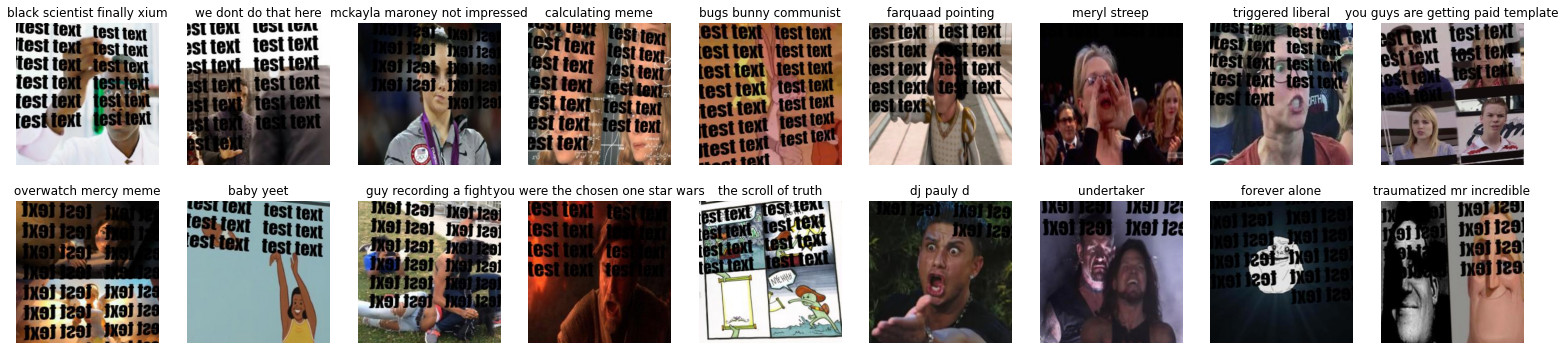

In [28]:
dls.train.show_batch(max_n=18, nrows=2)

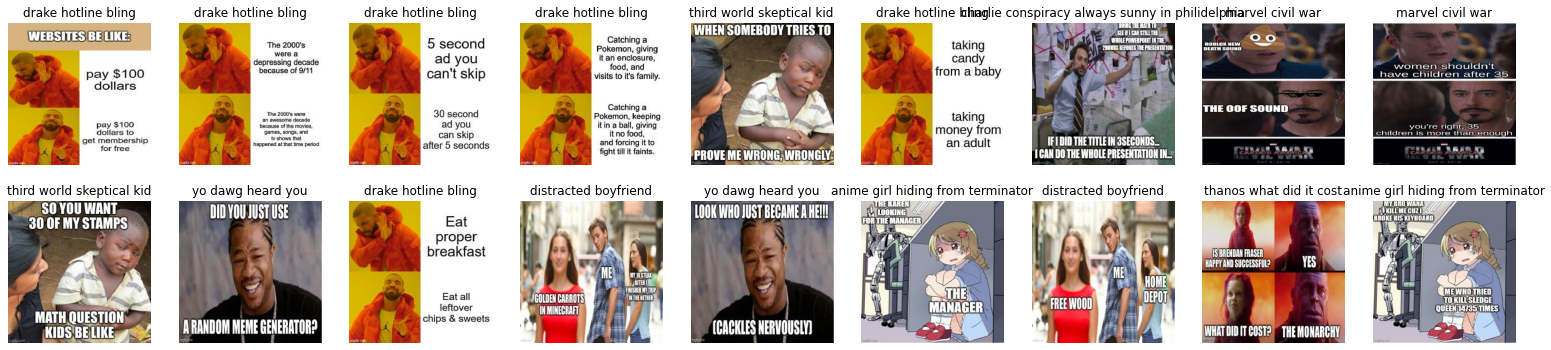

In [29]:
dls.valid.show_batch(max_n=18, nrows=2)

In [34]:
learn = vision_learner(dls, 
                       resnet18,
                       #weights=ResNet18_Weights.DEFAULT,
                       metrics=[partial(top_k_accuracy, k=3), accuracy],
                       )

c:\Users\yromm\.conda\envs\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\yromm\.conda\envs\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


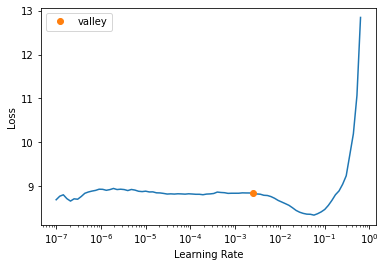

In [13]:
lr = learn.lr_find().valley

In [35]:
learn.fit_one_cycle(5,
                    #lr,
                    cbs=[EarlyStoppingCallback(monitor='top_k_accuracy', min_delta=0.001, patience=2),
                         SaveModelCallback(monitor='top_k_accuracy', fname='final',at_end=True)],
                    )

Better model found at epoch 0 with top_k_accuracy value: 0.5426749587059021.
Better model found at epoch 1 with top_k_accuracy value: 0.9326265454292297.
Better model found at epoch 2 with top_k_accuracy value: 0.9436122179031372.
Better model found at epoch 3 with top_k_accuracy value: 0.9542137384414673.
Better model found at epoch 4 with top_k_accuracy value: 0.9545210003852844.


In [36]:
learn.load(Path.cwd()/'models/final', with_opt=False)
learn.export(Path.cwd()/'models/model.pkl')

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=6)

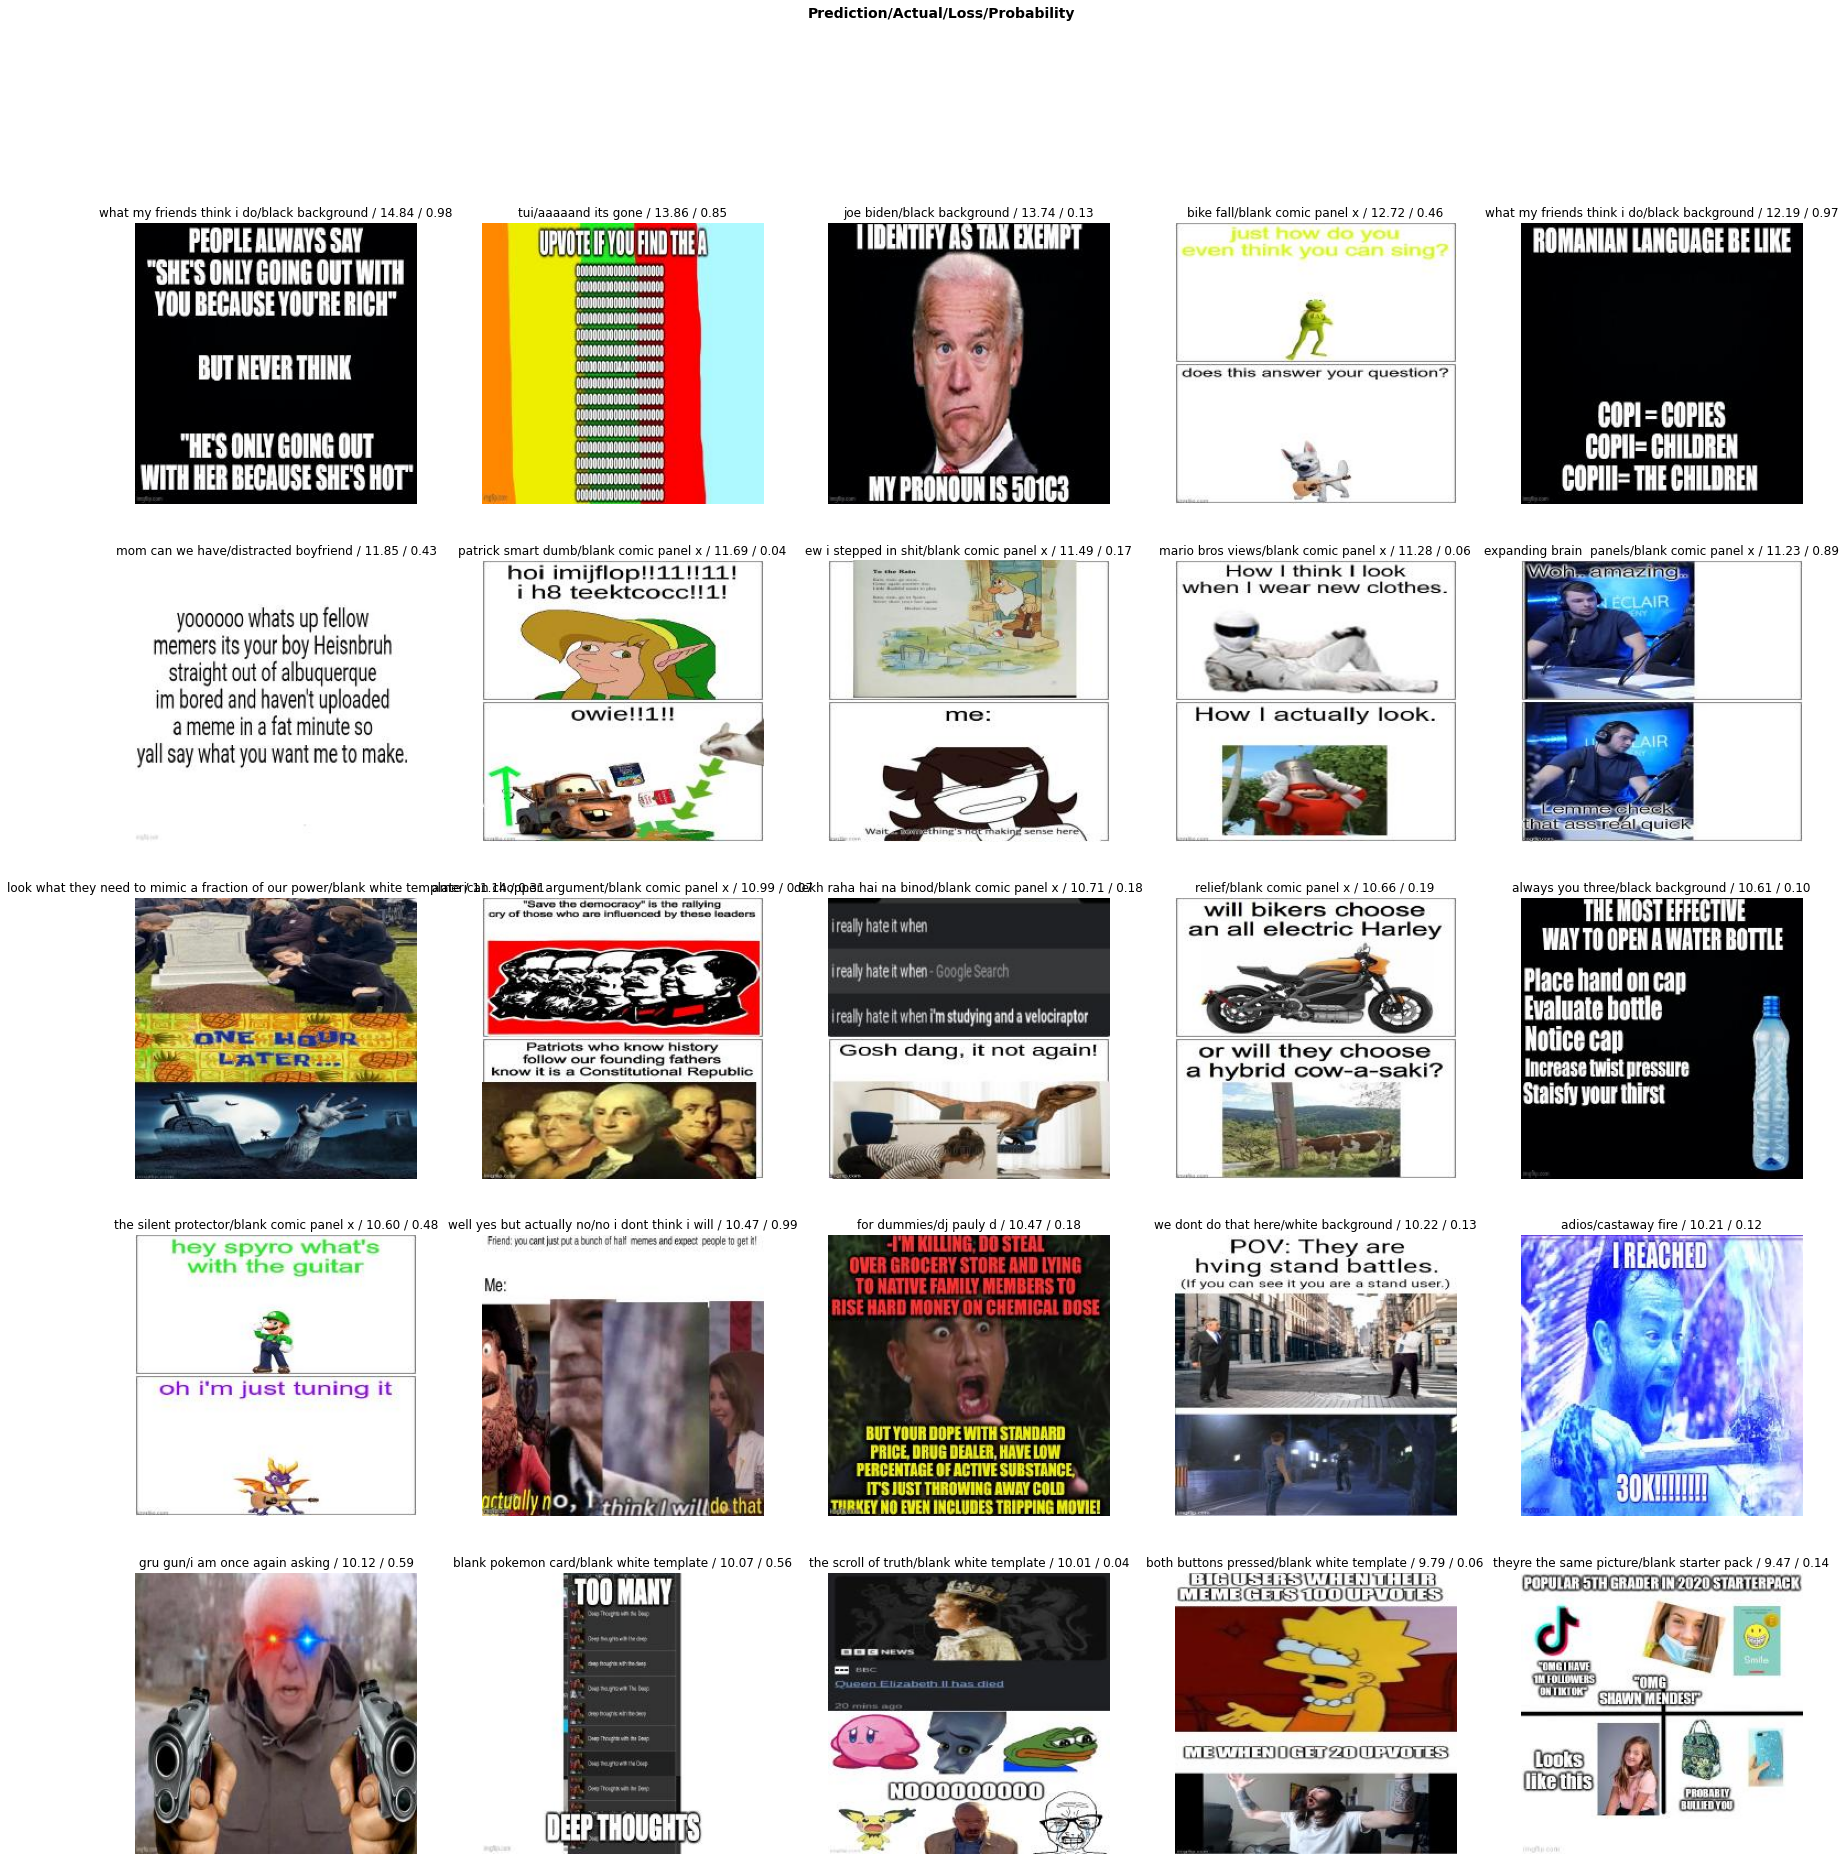

In [38]:
interp.plot_top_losses(25, nrows=5, figsize=(30,30))